# Lab | Products review

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re,string
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

In [74]:
df = pd.read_csv("./datasets/kindle_reviews_sampled.csv.zip")

In [75]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,130918,B0063LXXOA,"[0, 0]",4,I liked this story going back to visist the fi...,"01 16, 2013",A66QR0ZQ8YET8,K. Floyd,Every Second Counts,1358294400
1,464192,B00BU67NY4,"[0, 0]",5,Not your typical love story. Popsicle was beyo...,"03 19, 2013",A9I2OPQT76SPD,LUV2READ,Raunchy!!,1363651200
2,420209,B00B8ZR41E,"[1, 1]",5,I loved these and so will you. They brought al...,"04 29, 2013",A3QGO0LC8C5VFV,misty morse,Absolutely loved these stories,1367193600
3,500564,B00CG6R4ZK,"[0, 0]",5,"Very nice cozy look at the next step for the ""...","10 27, 2013",A2QSRP25LFCQ7X,"Pam ""SMB,SLT""",Great tidbit,1382832000
4,796721,B00HY03FJM,"[0, 0]",5,Oh God I cried like a freaking baby. I have no...,"03 17, 2014",A35X4ALOWRAYB4,Legit,Oh my lawd,1395014400


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78610 entries, 0 to 78609
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      78610 non-null  int64 
 1   asin            78610 non-null  object
 2   helpful         78610 non-null  object
 3   overall         78610 non-null  int64 
 4   reviewText      78609 non-null  object
 5   reviewTime      78610 non-null  object
 6   reviewerID      78610 non-null  object
 7   reviewerName    78338 non-null  object
 8   summary         78600 non-null  object
 9   unixReviewTime  78610 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 6.0+ MB


In [77]:
#Delete all features except overall, reviewText and summary
df = df.drop(['Unnamed: 0','asin', 'helpful', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'], axis=1)

In [78]:
df.isna().sum()

overall        0
reviewText     1
summary       10
dtype: int64

In [79]:
df.head()

,overall,reviewText,summary
0,4,I liked this story going back to visist the fi...,Every Second Counts
1,5,Not your typical love story. Popsicle was beyo...,Raunchy!!
2,5,I loved these and so will you. They brought al...,Absolutely loved these stories
3,5,"Very nice cozy look at the next step for the ""...",Great tidbit
4,5,Oh God I cried like a freaking baby. I have no...,Oh my lawd


In [80]:
#combine the reviewText and the summary features into one feature called reviewText - Be sure to add a space (' ') to seperate the two

df['reviewText'] = df['reviewText'] + ' ' + df['summary']

In [81]:
df.isna().sum()

overall        0
reviewText    11
summary       10
dtype: int64

In [82]:
df['reviewText'].fillna("",inplace = True) #fills empty/NaN values with an empty string ""

In [83]:
df.head()

,overall,reviewText,summary
0,4,I liked this story going back to visist the fi...,Every Second Counts
1,5,Not your typical love story. Popsicle was beyo...,Raunchy!!
2,5,I loved these and so will you. They brought al...,Absolutely loved these stories
3,5,"Very nice cozy look at the next step for the ""...",Great tidbit
4,5,Oh God I cried like a freaking baby. I have no...,Oh my lawd


In [84]:
df.overall.value_counts()

overall
5    45947
4    20385
3     7745
2     2661
1     1872
Name: count, dtype: int64

In [85]:
def review_sentiment(rating): #This function should return 1 or 0
    # Write a the code to replace rating of 1,2,3 with 0(not good) and 4,5 with 1(good) 
    '''
   This function replaces ratings of 1, 2, or 3 with 0 (indicating "not good")
    and ratings of 4 or 5 with 1 (indicating "good").
    
    Input:
        rating (int): The rating to be classified.
    
    Output: 
        int: 1 if the rating is 4 or 5, indicating "good" sentiment, 
             0 if the rating is 1, 2, or 3, indicating "not good" sentiment.
    '''
    sentiment = None

    if rating in [1,2,3]:
        sentiment = 0
    elif rating in [4,5]:
        sentiment = 1

    return sentiment

In [86]:
#Transform the overal feature based on the review_sentiment above. Hint: Use the apply method on the Series 'overall'
df['overall'] = df.overall.apply(review_sentiment)

In [87]:
df.head()

,overall,reviewText,summary
0,1,I liked this story going back to visist the fi...,Every Second Counts
1,1,Not your typical love story. Popsicle was beyo...,Raunchy!!
2,1,I loved these and so will you. They brought al...,Absolutely loved these stories
3,1,"Very nice cozy look at the next step for the ""...",Great tidbit
4,1,Oh God I cried like a freaking baby. I have no...,Oh my lawd


In [88]:
df.overall.value_counts()

overall
1    66332
0    12278
Name: count, dtype: int64

In [89]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [90]:
def clean_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = i.strip().lower()
            final_text.append(word)
    return " ".join(final_text) 

In [91]:
df['reviewText'] = df['reviewText'].apply(clean_text)

### Main difference between stratified and non-stratified splits:

Stratified Split: When using stratified sampling, the class distribution in the original dataset is preserved in both the training and testing sets. This helps ensure that the model sees a representative sample of all classes during training, leading to potentially better generalization performance. Stratified sampling is especially important when the class distribution is imbalanced.

Non-Stratified Split: In a non-stratified split, the data is randomly divided into training and testing sets without regard to the class distribution. As a result, the proportion of classes in the training and testing sets may differ from that in the original dataset. This can lead to issues, especially if the class distribution is skewed or imbalanced. The model may not be adequately trained on minority classes, leading to biased performance evaluation.



In [92]:
X = df['reviewText']
y = df['overall']

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)  #Use train_test_split function and assign 80% data to the training set and 20% to the test set.
#Should you consider a stratify split? Why?

In [93]:
print("Ratings Shape")
print(x_train.shape)
print(y_train.shape)
print("Labels Shape")
print(x_test.shape)
print(y_test.shape)


Ratings Shape
(62888,)
(62888,)
Labels Shape
(15722,)
(15722,)


# Answer
I applied a stratify split on this dataset, since there's an imbalance on ratings in the overall column with 66332 positive ratings and only 12278 negative. A stratify split ensures that the proportion of each class (rating) is preserved in both the training and testing sets and provides a more accurate representation of the dataset's distribution in both training and testing sets.

In [94]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,1))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (62888, 34033)
BOW_cv_test: (15722, 34033)


In [95]:
#Initialize and fit a multinomial Naive Bayes model to the training set
mnb = MultinomialNB()
mnb.fit(cv_train_reviews, y_train)

MultinomialNB()

In [96]:
#Return the predictions on the test set using the accuracy_score and/or other metrics of interest

mnb_pred = mnb.predict(cv_test_reviews)  #returns the predicted class labels for each test review

accuracy = accuracy_score(y_test, mnb_pred)
print("Multinomial Naive Bayes Accuracy:", accuracy)


Multinomial Naive Bayes Accuracy: 0.8389517873044142


In [97]:
#Use the classification_report function and print the result using the predicted results on the test set

print("\nClassification Report:")
print(classification_report(y_test, mnb_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.01      0.02      2456
           1       0.84      0.99      0.91     13266

    accuracy                           0.84     15722
   macro avg       0.51      0.50      0.46     15722
weighted avg       0.74      0.84      0.77     15722



In [98]:
cm_cv = confusion_matrix(y_test,mnb_pred)
cm_cv

array([[   22,  2434],
       [   98, 13168]])

In [99]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

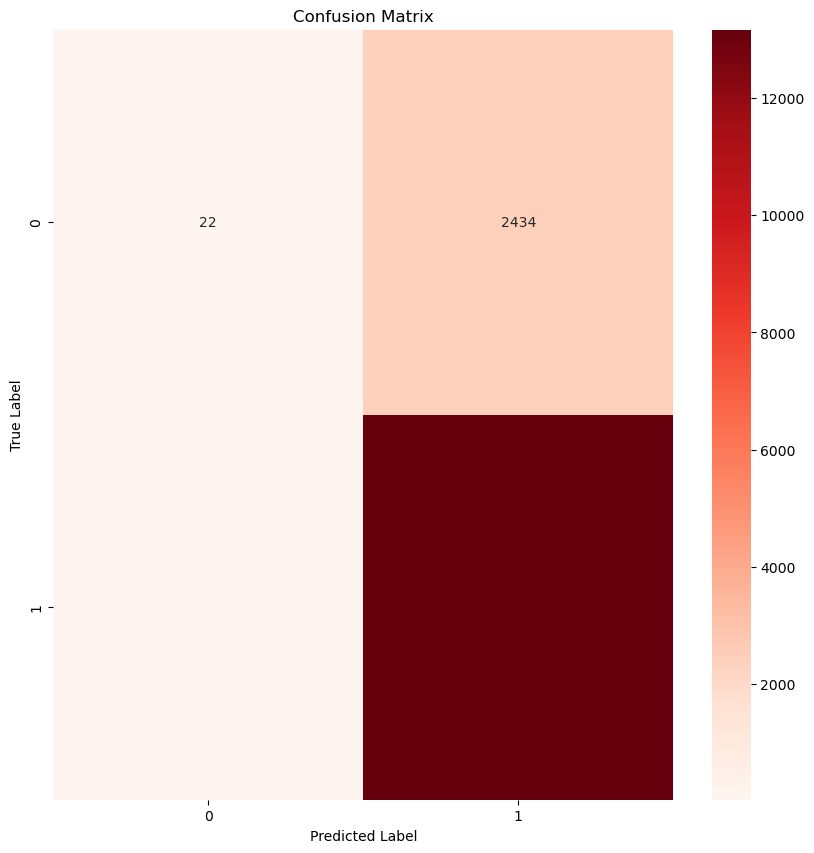

In [100]:
#Create a heat map to visualize the confusion matrix

plt.figure(figsize=(10, 10))
sns.heatmap(cm_cv, annot=True, cmap="Reds", fmt="d", 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
